In [1]:
# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("Fraud2.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Datatypes of the columns
df.dtypes


step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

C:\Users\Anders\AppData\Local\Temp\ipykernel_9304\2450264122.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='isFraud', palette='pastel')


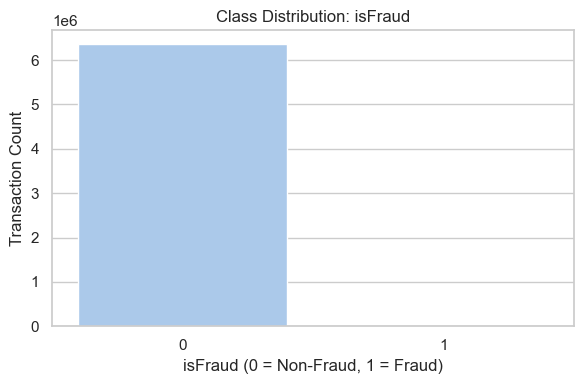

In [4]:

# Set visual style
sns.set(style="whitegrid")

# Plot: Fraud vs Non-Fraud count
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='isFraud', palette='pastel')
plt.title("Class Distribution: isFraud")
plt.xlabel("isFraud (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Count")
plt.tight_layout()
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Copying dataset to avoid modifying the original
df_model = df.copy()

# Drop identifiers that don't help modeling
df_model.drop(columns=['nameOrig', 'nameDest'], inplace=True)

# Encoding 'type' using LabelEncoder
le = LabelEncoder()
df_model['type'] = le.fit_transform(df_model['type'])

# Define features and target
X = df_model.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df_model['isFraud']

# Display the cleaned feature set
X.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

# Sample the dataset to reduce size (e.g., 50,000 rows)
sample_size = 100000  # Adjust this number based on your memory capacity
X_sample = X.sample(n=sample_size, random_state=10)
y_sample = y.loc[X_sample.index]  # Match the same rows

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_sample, test_size=0.3, stratify=y_sample, random_state=10
)

# Apply SMOTE
smote = SMOTE(random_state=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display resampled class distribution
print(pd.Series(y_train_resampled).value_counts())


isFraud
0    69900
1    69900
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Hyperparameter distributions
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # Solvers that support L1 and L2
}

# Initialize model
logreg = LogisticRegression(max_iter=1000, random_state=10)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Use best estimator
best_logreg = random_search.best_estimator_

# Predict on the original test set
y_pred_lr = best_logreg.predict(X_test)
y_proba_lr = best_logreg.predict_proba(X_test)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nLogistic Regression 📊 Classification Report")
print(classification_report(y_test, y_pred_lr, digits=4))


auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"AUC: {auc_lr:.4f}")



Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}

Logistic Regression 📊 Classification Report
              precision    recall  f1-score   support

           0     0.9999    0.9828    0.9913     29957
           1     0.0704    0.9070    0.1307        43

    accuracy                         0.9827     30000
   macro avg     0.5351    0.9449    0.5610     30000
weighted avg     0.9985    0.9827    0.9900     30000

AUC: 0.9544


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define hyperparameter distributions
param_dist = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize model
dt = DecisionTreeClassifier(random_state=10)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fit model on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_dt = random_search.best_estimator_

# Predict on the original test set
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nDecision Tree 🌳 Classification Report")
print(classification_report(y_test, y_pred_dt, digits=4))

auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"AUC: {auc_dt:.4f}")



Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'}

Decision Tree 🌳 Classification Report
              precision    recall  f1-score   support

           0     0.9998    0.9897    0.9947     29957
           1     0.1066    0.8605    0.1897        43

    accuracy                         0.9895     30000
   macro avg     0.5532    0.9251    0.5922     30000
weighted avg     0.9985    0.9895    0.9935     30000

AUC: 0.9290


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define hyperparameter distributions
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize model
rf = RandomForestClassifier(random_state=10)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fit model on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_

# Predict on the original test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nRandom Forest 🌲 Classification Report")
print(classification_report(y_test, y_pred_rf, digits=4))

auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC: {auc_rf:.4f}")


Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

Random Forest 🌲 Classification Report
              precision    recall  f1-score   support

           0     0.9997    0.9987    0.9992     29957
           1     0.4658    0.7907    0.5862        43

    accuracy                         0.9984     30000
   macro avg     0.7327    0.8947    0.7927     30000
weighted avg     0.9989    0.9984    0.9986     30000

AUC: 0.9988


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define hyperparameter distributions
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=10)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_xgb = random_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nXGBoost ⚡ Classification Report")
print(classification_report(y_test, y_pred_xgb, digits=4))

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC: {auc_xgb:.4f}")



C:\Users\Anders\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [20:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.9}

XGBoost ⚡ Classification Report
              precision    recall  f1-score   support

           0     0.9998    0.9989    0.9993     29957
           1     0.5294    0.8372    0.6486        43

    accuracy                         0.9987     30000
   macro avg     0.7646    0.9181    0.8240     30000
weighted avg     0.9991    0.9987    0.9988     30000

AUC: 0.9994


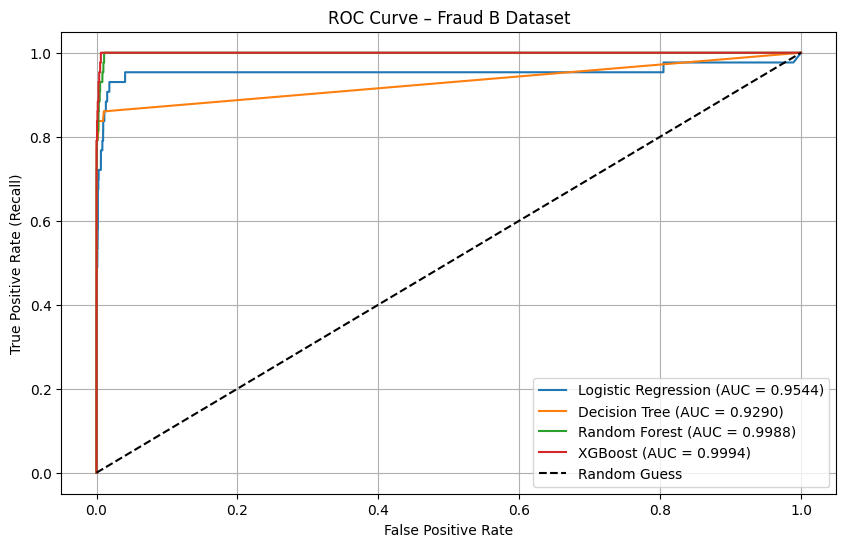

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curves and AUCs for the fraud2 dataset
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Calculate AUC values
auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve – Fraud B Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

